In [78]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir,'code'))
from model_src import fwrf_fit as fwrf_fit
from model_src import fwrf_predict as fwrf_predict
from model_src import texture_statistics as texture_statistics

from model_fitting import initialize_fitting

fpX = np.float32


In [2]:
root_dir

'/user_data/mmhender/imStat/notebooks'

In [96]:
subject=1; roi=None; up_to_sess=1; n_ori=8; n_sf=4; sample_batch_size=50; voxel_batch_size=100; 

include_pixel=False
include_simple=False 
include_complex=True
include_autocorrs=False
include_crosscorrs=False

zscore_features=False

nonlin_fn=False; 

ridge=False

padding_mode = 'circular'; 
debug=False; shuffle_images=False; random_images=False; random_voxel_data=False; do_fitting=True; do_val=True; do_partial=True; date_str=None; shuff_rnd_seed=0

In [97]:
device = initialize_fitting.init_cuda()
nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
model_name, feature_types_exclude = initialize_fitting.get_model_name(ridge, n_ori, n_sf, include_pixel, include_simple, include_complex, include_autocorrs, include_crosscorrs)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [98]:
if do_fitting==False and date_str is None:
    raise ValueError('if you want to start midway through the process (--do_fitting=False), then specify the date when training result was saved (--date_str).')

if do_fitting==True and date_str is not None:
    raise ValueError('if you want to do fitting from scratch (--do_fitting=True), specify --date_str=None (rather than entering a date)')

output_dir, fn2save = initialize_fitting.get_save_path(root_dir, subject, model_name, shuffle_images, random_images, random_voxel_data, debug, date_str)

def save_all():
    print('\nSaving to %s\n'%fn2save)
    torch.save({
    'feature_table_simple': _gaborizer_simple.feature_table,
    'sf_tuning_masks_simple': _gaborizer_simple.sf_tuning_masks, 
    'ori_tuning_masks_simple': _gaborizer_simple.ori_tuning_masks,
    'cyc_per_stim_simple': _gaborizer_simple.cyc_per_stim,
    'orients_deg_simple': _gaborizer_simple.orients_deg,
    'orient_filters_simple': _gaborizer_simple.orient_filters,  
    'feature_table_complex': _gaborizer_complex.feature_table,
    'sf_tuning_masks_complex': _gaborizer_complex.sf_tuning_masks, 
    'ori_tuning_masks_complex': _gaborizer_complex.ori_tuning_masks,
    'cyc_per_stim_complex': _gaborizer_complex.cyc_per_stim,
    'orients_deg_complex': _gaborizer_complex.orients_deg,
    'orient_filters_complex': _gaborizer_complex.orient_filters,  
    'aperture': aperture,
    'aperture_rf_range': aperture_rf_range,
    'models': models,
    'include_autocorrs': include_autocorrs,
    'feature_info':feature_info,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': brain_nii_shape,
    'image_order': image_order,
    'voxel_index': voxel_index,
    'voxel_roi': voxel_roi,
    'voxel_ncsnr': voxel_ncsnr, 
    'best_params': best_params,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'best_losses': best_losses,
    'val_cc': val_cc,
    'val_r2': val_r2,   
    'val_cc_partial': val_cc_partial,
    'val_r2_partial': val_r2_partial,   
    'features_each_model_val': features_each_model_val,
    'voxel_feature_correlations_val': voxel_feature_correlations_val,
    'zscore_features': zscore_features,
    'nonlin_fn': nonlin_fn,
    'padding_mode': padding_mode,
    'n_prf_sd_out': n_prf_sd_out,
    'autocorr_output_pix': autocorr_output_pix,
    'debug': debug,
    'up_to_sess': up_to_sess,
    'shuff_rnd_seed': shuff_rnd_seed
    }, fn2save, pickle_protocol=4)


# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = initialize_fitting.get_voxel_info(mask_root, beta_root, subject, roi)

# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_single_trial_data, val_voxel_single_trial_data, \
    n_voxels, n_trials_val, image_order = initialize_fitting.get_data_splits(nsd_root, beta_root, stim_root, subject, voxel_mask, up_to_sess, 
                                                                             shuffle_images=shuffle_images, random_images=random_images, random_voxel_data=random_voxel_data)

Time Stamp: Jul-13-2021_1609

Will save final output file to /user_data/mmhender/model_fits/S01/texture_OLS_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations/Jul-13-2021_1609/

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1'

In [99]:
# Set up the filters
_gaborizer_complex, _gaborizer_simple, _fmaps_fn_complex, _fmaps_fn_simple = initialize_fitting.get_feature_map_simple_complex_fn(n_ori, n_sf, padding_mode=padding_mode, device=device, nonlin_fn=nonlin_fn)

# Params for the spatial aspect of the model (possible pRFs)
#     aperture_rf_range=0.8 # using smaller range here because not sure what to do with RFs at edges...
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

 # Initialize the "texture" model which builds on first level feature maps
autocorr_output_pix=5
n_prf_sd_out=2
_texture_fn = texture_statistics.texture_feature_extractor(_fmaps_fn_complex, _fmaps_fn_simple, sample_batch_size=sample_batch_size, feature_types_exclude=feature_types_exclude, autocorr_output_pix=autocorr_output_pix, n_prf_sd_out=n_prf_sd_out, aperture=aperture, device=device)

# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]

Possible lambda values are:
[0. 0.]


In [100]:
debug=True
gc.collect()
torch.cuda.empty_cache()
print('\nStarting training...\n')
if shuff_rnd_seed==0:
    shuff_rnd_seed = int(time.strftime('%M%H%d', time.localtime()))
best_losses, best_lambdas, best_params, feature_info = fwrf_fit.fit_texture_model_ridge(trn_stim_data, trn_voxel_data, _texture_fn, models, lambdas, \
    zscore=zscore_features, voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=True, add_bias=True, debug=debug, shuff_rnd_seed=shuff_rnd_seed)
# note there's also a shuffle param in the above fn call, that determines the nested heldout data for lambda and param selection. always using true.
print('\nDone with training\n')

val_cc=None
val_r2=None
val_cc_partial=None
val_r2_partial=None
features_each_model_val=None;
voxel_feature_correlations_val=None;


Starting training...

trn_size = 619 (90.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
Seeding random number generator: seed is 91613


model 0

Computing pixel-level statistics...
time elapsed = 0.03236
Computing complex cell features...
time elapsed = 0.48768
Computing simple cell features...
time elapsed = 0.40574
SKIPPING HIGHER-ORDER CORRELATIONS...
time elapsed = 0.04502
Final size of features concatenated is [688 x 32]
Feature types included are:
['complex_feature_means']
fitting model    0 of 875 , voxels [ 14900:14912 ] of 14913
model 1

Computing pixel-level statistics...
time elapsed = 0.03012
Computing complex cell features...
time elapsed = 0.46776
Computing simple cell features...
time elapsed = 0.40706
SKIPPING HIGHER-ORDER CORRELATIONS...
time elapsed = 0.04583
Final size of features concatenated is [688 x 32]
Feature types included are:
['complex_feature_means']
fitting model    1 of 875 , voxels [ 14900:14912 ] of 14913
-

In [105]:
debug=True
# _texture_fn = texture_statistics.texture_feature_extractor(_fmaps_fn_complex, _fmaps_fn_simple, sample_batch_size=sample_batch_size, feature_types_exclude=feature_types_exclude, autocorr_output_pix=autocorr_output_pix, n_prf_sd_out=n_prf_sd_out, aperture=aperture, device=device)
gc.collect()
torch.cuda.empty_cache()
t = time.time()
val_cc, val_r2 = validate_texture_model(best_params, models, val_voxel_single_trial_data, val_stim_single_trial_data, _texture_fn, sample_batch_size=sample_batch_size, voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)
# val_cc, val_r2 = validate_texture_model(best_params, models, trn_voxel_data, trn_stim_data, _texture_fn, sample_batch_size=sample_batch_size, voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)
           
elapsed = time.time() - t
print('elapsed time for val: %.5f'%elapsed)


Getting model predictions on validation set...

Getting features for prf 0: [x,y,sigma] is [-0.55 -0.55 0.0400]
Computing pixel-level statistics...
time elapsed = 0.04009
Computing complex cell features...
time elapsed = 0.10671
Computing simple cell features...
time elapsed = 0.08864
SKIPPING HIGHER-ORDER CORRELATIONS...
time elapsed = 0.04970
Final size of features concatenated is [62 x 32]
Feature types included are:
['complex_feature_means']
Getting features for prf 1: [x,y,sigma] is [-0.49 -0.55 0.0400]
Computing pixel-level statistics...
time elapsed = 0.00574
Computing complex cell features...
time elapsed = 0.08471
Computing simple cell features...
time elapsed = 0.07020
SKIPPING HIGHER-ORDER CORRELATIONS...
time elapsed = 0.04634
Final size of features concatenated is [62 x 32]
Feature types included are:
['complex_feature_means']
Getting predictions for voxels [0-99] of 14913
Getting predictions for voxels [100-199] of 14913
Getting predictions for voxels [200-299] of 14913


  0%|          | 0/14913 [00:00<?, ?it/s]/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
  3%|▎         | 399/14913 [00:00<00:03, 3988.74it/s]


Evaluating correlation coefficient on validation set...



100%|██████████| 14913/14913 [00:03<00:00, 4458.90it/s]

elapsed time for val: 3.87481


In [90]:
def get_corr(dat1, dat2):
    
    dat1 = np.squeeze(dat1)
    dat2 = np.squeeze(dat2)
    assert(len(dat1.shape)==1)
    assert(len(dat2.shape)==1)
    assert(len(dat1)==len(dat2))
    n=len(dat1)
    
    m1 = np.sum(dat1)/n
    m2 = np.sum(dat2)/n
    
    cov = np.sum((dat1-m1)*(dat2-m2))/(n-1)
    
    sd1 = np.sqrt(np.sum((dat1-m1)**2)/(n-1))
    sd2 = np.sqrt(np.sum((dat2-m2)**2)/(n-1))
    
    corr = cov/(sd1*sd2)
    
    return corr

In [91]:
def get_r2(actual,predicted):
  
    actual = np.squeeze(actual)
    predicted = np.squeeze(predicted)
    assert(len(actual.shape)==1)
    assert(len(predicted.shape)==1)
    assert(len(actual)==len(predicted))
  
    # calculate r2 for this fit.
    ssres = np.sum((predicted - actual)**2);
    sstot = np.sum((actual - np.mean(actual))**2);
    
    r2 = 1-(ssres/sstot)
    
    return r2

Text(0.5, 0.98, 'texture_OLS_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations')

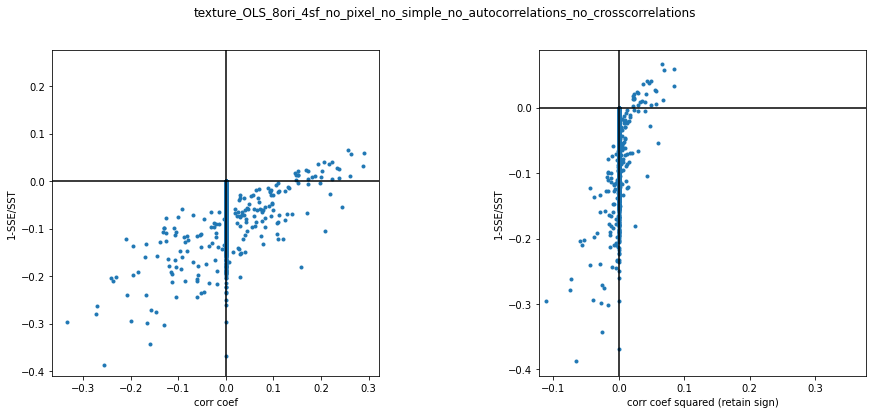

In [106]:
import matplotlib.pyplot as plt



plt.figure(figsize=(16,6));
plt.subplot(1,2,1)
plt.plot(val_cc, val_r2, '.')
plt.axhline(0,color='k')
plt.axvline(0,color='k')
# plt.plot([-1,1],[-1,1],color='k')
plt.axis('square')
plt.xlabel('corr coef')
plt.ylabel('1-SSE/SST')
# plt.ylim([-1,1]); plt.xlim([-1,1])


plt.subplot(1,2,2)
plt.plot(np.sign(val_cc)*val_cc**2, val_r2,'.')
plt.axhline(0,color='k')
plt.axvline(0,color='k')
# plt.plot([-1,1],[-1,1],color='k')
plt.axis('square')
plt.xlabel('corr coef squared (retain sign)')
plt.ylabel('1-SSE/SST')
# plt.ylim([-1,1]); plt.xlim([-1,1])

plt.suptitle(model_name)

In [77]:
import scipy
import sklearn

np.random.seed(858459)
dat1 = np.random.normal(0,1,[100])
dat2 = np.random.normal(0,1,[100])

vc = get_corr(dat1, dat2)
vc2 = scipy.stats.pearsonr(dat1, dat2)[0]
vr = get_r2(dat1, dat2)
vr2 = sklearn.metrics.r2_score(dat1, dat2)
vr3 = get_r2(dat2, dat1)
vr4 = sklearn.metrics.r2_score(dat2, dat1)
print([vc, vc2, vr, vr2, vr3, vr4])

print([vc, vc**2, vr])


[0.2343393607719877, 0.23433936077198764, -0.7006184145670962, -0.7006184145670962, -0.3981002534507645, -0.3981002534507645]
[0.2343393607719877, 0.0549149360070238, -0.7006184145670962]


In [76]:
np.random.seed(564555)
X = np.random.normal(0,1,[10,5])
X_withint = np.concatenate([X, np.ones([X.shape[0],1])], axis=1)
Y = np.random.normal(0,1,[10,1])

X_cross = X_withint.T @ np.linalg.pinv(np.matmul(X_withint, X_withint.T))
w = X_cross @ Y

Y_hat = X_withint @ w

rval = get_r2(Y, Y_hat)
rval2 = sklearn.metrics.r2_score(Y, Y_hat)
cval = get_corr(Y, Y_hat)
# cval2 = scipy.stats.pearsonr(np.squeeze(Y), np.squeeze(Y_hat))[0]
cval2 = np.corrcoef(np.squeeze(Y), np.squeeze(Y_hat))[0,1]

print([cval, cval**2, rval])
print([cval2, cval2**2, rval2])

[0.9323978554990525, 0.869365760939232, 0.869365760939232]
[0.9323978554990524, 0.8693657609392318, 0.869365760939232]


In [8]:
# cov = get_corr(dat1, dat2)
m1 = np.mean(dat1)
m2 = np.mean(dat2)

cov = np.sum((dat1-m1)*(dat2-m2))/(len(dat1)-1)

cov2 = np.cov(dat1, dat2)[0,1]

print([cov, cov2])

[0.25449883380559896, 0.254498833805599]


In [12]:
sd = np.sqrt(np.sum((dat1-m1)**2)/(len(dat1)))
sd2 = np.std(dat1)
print([sd, sd2])

[0.9873490994804737, 0.9873490994804737]


In [20]:
vc = get_corr(dat1, dat2)
vc2 = scipy.stats.pearsonr(dat1, dat2)[0]

print([vc, vc2])

[0.2343393607719877, 0.23433936077198764]


In [64]:
np.var(dat2)

1.1857961384840074